<a href="https://colab.research.google.com/github/andrewbhennessy/CS4641-Customer-Segmentation-Analysis/blob/main/Mid_Project_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
from google.colab import drive

In [10]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Customer Data segmentation

Link to Our Data: https://www.kaggle.com/carrie1/ecommerce-data

How to Mount Data:
1. Follow the Instructions in the Auth Cell
2. Click the file icon
3. Navigate to drive then the folder that I have shared should be CS4641 something
4. right click on the file and copy path to the file and input into the next code cell as the first paramater in quotes. 

Example:


```
data = pd.read_csv('/content/drive/My Drive/CS4641 Customer Data Segmentation/data.csv', encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})
```



In [12]:
data = pd.read_csv("/content/drive/My Drive/CS4641 Customer Data Segmentation/data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})

# 1. Introduction/Background
> The COVID-19 pandemic has greatly affected the way all companies advertise for their businesses. Now more than ever, online presence and advertising are necessary to attract customers. While each customer is unique, a similar group of customers can be targeted in an advertisement. This is almost always more successful than making a generic advertisement aimed at the entire population. Advertisements aimed at certain subsets can save money and increase company traffic.
# 2. Problem definition
> Our project will use customer spending datasets to group customers together, allowing advertising to become specialized to each group. With this, companies can target these groups and make advertisements specifically aimed at each of them. This will improve the success rate of advertisements and bring in more revenue from customers(Modukuru n.pag).
# 3. Data Collection
> ## 3.1 Data Abstract
> ## 3.2 Data Cleaning Procedure
1. Remove Nan Customer ID datapoints
2. deal with negative quantities
3. Weight Discounts, Cancelled Orders, Regular orders 
>> ``` weights = {'D':0.5,'C':-1,'R':1} ```
4. Make new database based upon each customer with
>> 4.1 RFM Segmentation
>>> 4.1.1 Recency (how recent did customer buy from store?)
>>> 4.1.2 Frequency (how often did customer buy from store?)
>>> 4.1.3 Monetary (how much did customer spend?)
>> 4.2 divide into tiered groups (4 tiers)
>>> 4.2.1 DBSCAN

> ## 3.3 Summary of Data


In [13]:
data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


Text(0.5, 1.0, 'Ratio of missing values per columns')

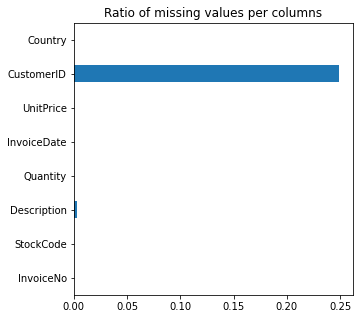

In [20]:
plt.figure(figsize=(5, 5))
data.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

# 4. Methods
> We will be using DBScan to specify our groups. DBScan is defined as density based spatial clustering of applications with noise. Points with lower density will be treated as noise or outliers. Core points will represent the customers that a targeted advertisement is most likely to attract, border points will represent customers who may have some interest in a targeted advertisement aimed at their group, and outliers will have minimal to no interest in any targeted advertisement. Because DBScan is very sensitive to parameters, we will need to perform extensive testing to find the most optimal combination of epsilon value and number of minimum points(Hossain n.pag.)
# 5. Results
> ## 1.1 Potential Results
>> Classify customer population into some number of specific groups (clusters). Companies can then create advertisements aiming towards attracting the different categories of customers.
> ## 1.2 Results
>> LOREM IPSUM
# 6. Discussion
> ## 1.1 Initial Discussion
>> DBScan is a performative method that can categorize customers based on their spending habits and interests. However, the method is very sensitive to the two parameters: epsilon and minimum number of points. Different values for parameters will partition customers into different clusters, and choosing impractical parameter values lead to severe impact on customers’ experiences. Therefore, deciding the ideal values for each parameter using different analysis such as the elbow effect will be crucial. Another possible difficulty is partitioning a dataset with similar densities. If the dataset contains many groups of customers with a similar size of density, DBScan may struggle separating them. Despite these challenges, DBScan is still a phenomenal method for categorizing customers over other clustering methods such as K-means. Density based clustering is capable of handling outliers and does not require to input the number of clusters. Finding the ideal number of clusters will be extremely hard since there may be tons of people who do not share similar spending patterns and interests in the given dataset. In addition, DBScan is competent in connecting nearby clusters using density reachability and connectivity nature so each customer will not be fully restricted to its own group. Applying this method to partition customers will provide a tremendous benefit to a company and the customers will be able to not only enjoy within their interests but also explore further by being introduced with new topics that other customers with similar interests like(Sekhar & Prasanna n.pag).
> ## 1.2 Final Discussion
>> Lorem IPSUM
# 7 References
> 1.  Hossain, Shahadat. “Customer Segmentation Using Centroid Based and Density Based Clustering Algorithms.” Customer Segmentation Using Centroid Based and Density Based Clustering Algorithms - IEEE Conference Publication, 1 Feb. 2018, ieeexplore.ieee.org/document/8275249.

> 2. Modukuru, Pranay. “Customer Segmentation and Acquisition Using Machine Learning.” Medium, Towards Data Science, 19 Apr. 2020, towardsdatascience.com/customer-segmentation-and-acquisition-using-machine-learning-a219ce0ec139.

> 3. Sekhar, Babu B, and Prasanna P Lakshmi. “Customer Data Clustering Using Density Based Algorithm.” Research Gate, International Journal of Engineering & Technology, May 2018, www.researchgate.net/publication/325881992_Customer_Data_Clustering_using_Density_based_algorithm.